# Chapter 5 - AutoRegressive Integrated Moving Average (ARIMA) Models

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from statsmodels.tools.eval_measures import rmspe, rmse
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima_process import ArmaProcess
from pmdarima.arima import CHTest


import warnings
warnings.filterwarnings('ignore')

## 5.24 Table B.10 contains 7 years of monthly data on the number of airline miles flown in the United Kingdom. 
This is seasonal data.

    a. Using the first 6 years of data, develop an appropriate ARIMA model and a procedure for these data.
    
    b. Explain how prediction intervals would be computed.
    
    c. Make one-step-ahead forecasts of the last 12 months. Determine the forecast errors. How well did your procedure work in forecasting the new data?

In [3]:
# Raw data as alternating Month and Miles values
raw_data = [
    ("Jan-1964", 7.269), ("Feb-1964", 6.775), ("Mar-1964", 7.819), ("Apr-1964", 8.371),
    ("May-1964", 9.069), ("Jun-1964", 10.248), ("Jul-1964", 11.030), ("Aug-1964", 10.882),
    ("Sep-1964", 10.333), ("Oct-1964", 9.109), ("Nov-1964", 7.685), ("Dec-1964", 7.682),
    ("Jan-1965", 8.350), ("Feb-1965", 7.829), ("Mar-1965", 8.829), ("Apr-1965", 9.948),
    ("May-1965", 10.638), ("Jun-1965", 11.253), ("Jul-1965", 11.424), ("Aug-1965", 11.391),
    ("Sep-1965", 10.665), ("Oct-1965", 9.396), ("Nov-1965", 7.775), ("Dec-1965", 7.933),
    ("Jan-1966", 8.186), ("Feb-1966", 7.444), ("Mar-1966", 8.484), ("Apr-1966", 9.864),
    ("May-1966", 10.252), ("Jun-1966", 12.282), ("Jul-1966", 11.637), ("Aug-1966", 11.577),
    ("Sep-1966", 12.417), ("Oct-1966", 9.637), ("Nov-1966", 8.094), ("Dec-1966", 9.280),
    ("Jan-1967", 8.334), ("Feb-1967", 7.899), ("Mar-1967", 9.994), ("Apr-1967", 10.078),
    ("May-1967", 10.801), ("Jun-1967", 12.953), ("Jul-1967", 12.222), ("Aug-1967", 12.246),
    ("Sep-1967", 13.281), ("Oct-1967", 10.366), ("Nov-1967", 8.730), ("Dec-1967", 9.614),
    ("Jan-1968", 8.639), ("Feb-1968", 8.772), ("Mar-1968", 10.894), ("Apr-1968", 10.455),
    ("May-1968", 11.179), ("Jun-1968", 10.588), ("Jul-1968", 10.794), ("Aug-1968", 12.770),
    ("Sep-1968", 13.812), ("Oct-1968", 10.857), ("Nov-1968", 9.290), ("Dec-1968", 10.925),
    ("Jan-1969", 9.491), ("Feb-1969", 8.919), ("Mar-1969", 11.607), ("Apr-1969", 8.852),
    ("May-1969", 12.537), ("Jun-1969", 14.759), ("Jul-1969", 13.667), ("Aug-1969", 13.731),
    ("Sep-1969", 15.110), ("Oct-1969", 12.185), ("Nov-1969", 10.645), ("Dec-1969", 12.161),
    ("Jan-1970", 10.840), ("Feb-1970", 10.436), ("Mar-1970", 13.589), ("Apr-1970", 13.402),
    ("May-1970", 13.103), ("Jun-1970", 14.933), ("Jul-1970", 14.147), ("Aug-1970", 14.057),
    ("Sep-1970", 16.234), ("Oct-1970", 12.389), ("Nov-1970", 11.594), ("Dec-1970", 12.772),
]

# Convert to DataFrame
df_air_miles = pd.DataFrame(raw_data, columns=['Month', 'Miles'])

# Convert 'Month' column to datetime format and set as index
df_air_miles['Month'] = pd.to_datetime(df_air_miles['Month'], format='%b-%Y')
df_air_miles.set_index('Month', inplace=True)

# Display the first rows
df_air_miles.head()

,Miles
Month,
1964-01-01,7.269
1964-02-01,6.775
1964-03-01,7.819
1964-04-01,8.371
1964-05-01,9.069


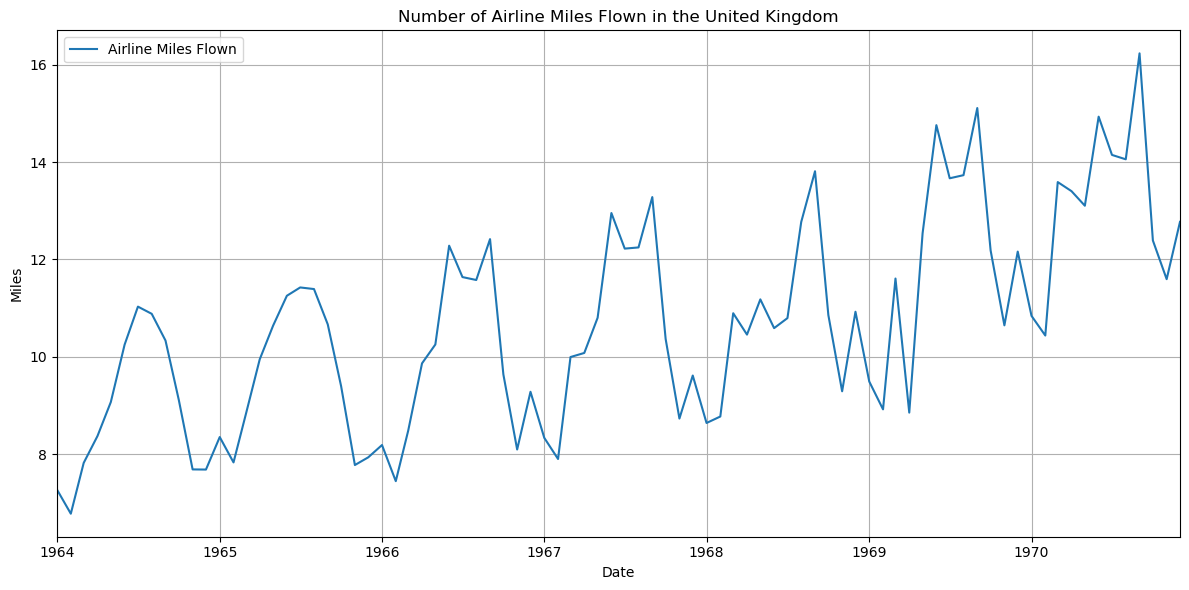

In [30]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

plt.plot(df_air_miles.index, df_air_miles['Miles'], label='Airline Miles Flown')     

plt.title('Number of Airline Miles Flown in the United Kingdom')                      
plt.xlabel('Date')                                        
plt.ylabel('Miles')  
plt.xlim(pd.to_datetime('1964-01-01'), pd.to_datetime('1970-12-01'))
plt.grid(True)                                            
plt.legend()                                             
plt.tight_layout()                                       
plt.show();

In [38]:
def determine_nonseasonal_d(series, max_d=2, alpha=0.05):
    
    for d in range(0, max_d + 1):
        if d == 0:
            tested_series = series.dropna()
        else:
            tested_series = series.diff(d).dropna()
        
        adf_result = adfuller(tested_series)
        p_value = adf_result[1]
        
        print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")
        
        if p_value < alpha:
            print(f"-> Series is stationary after differencing d = {d}")
            return d
    
    print("-> Series is non-stationary even after maximum differencing.")
    return max_d
    

d = determine_nonseasonal_d(air_series)
print(f"\nFinal non-seasonal differencing term (d): {d}")

d = 0 | ADF Statistic = 0.2847, p-value = 0.9766
d = 1 | ADF Statistic = -4.0768, p-value = 0.0011
-> Series is stationary after differencing d = 1

Final non-seasonal differencing term (d): 1


In [39]:
def determine_seasonal_d(serie, seasonal_period=12, max_D=2, alpha=0.05):
    
    for D in range(0, max_D + 1):
        if D == 0:
            tested_series = serie.dropna()
        else:
            tested_series = serie.diff(seasonal_period * D).dropna()

        adf_result = adfuller(tested_series)
        p_value = adf_result[1]

        print(f"D = {D} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")
        
        if p_value < alpha:
            print(f"-> Series is stationary after seasonal differencing D = {D}")
            return D

    print("\n-> Series is non-stationary even after maximum seasonal differencing.")
    return max_D

D = determine_seasonal_d(air_series, seasonal_period=12)
print(f"\nFinal seasonal differencing term (D): {D}")

D = 0 | ADF Statistic = 0.2847, p-value = 0.9766
D = 1 | ADF Statistic = -3.1328, p-value = 0.0242
-> Series is stationary after seasonal differencing D = 1

Final seasonal differencing term (D): 1


    D = 1

In [6]:
# Split the data
train = df_air_miles[df_air_miles.index.year < 1970]     # All data before 1970
test = df_air_miles[df_air_miles.index.year == 1970]     # All data in 1970

# Show the results
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print()
train.tail(), print(), test.head()

Train shape: (72, 1)
Test shape: (12, 1)




(             Miles
 Month             
 1969-08-01  13.731
 1969-09-01  15.110
 1969-10-01  12.185
 1969-11-01  10.645
 1969-12-01  12.161,
 None,
              Miles
 Month             
 1970-01-01  10.840
 1970-02-01  10.436
 1970-03-01  13.589
 1970-04-01  13.402
 1970-05-01  13.103)

In [7]:
air_series = train['Miles']

In [8]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(air_series)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: 0.2847
p-value: 0.9766

p-value > alpha; H0: Not Stationary


In [9]:
# Difference the series if non-stationary
diff_series = air_series.diff().dropna()

# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(diff_series)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -4.0768
p-value: 0.0011

p-value < alpha; Ha: Stationary


    d = 1

In [15]:
# Define the seasonal periods to test (2 to 50 inclusive)
seasonal_periods = list(range(2, 51))

# Store all seasonal differencing terms
d_values = []

# Loop over seasonal periods and run the Canova-Hansen test
for S in seasonal_periods:
    ch_test = CHTest(m=S)   # Initialize the CHTest with the seasonal period
    D = ch_test.estimate_seasonal_differencing_term(air_series)  # Estimate D
    d_values.append((S, D))  # Save the result

    if D != 0:
        print(f"Testing with seasonal period = {S}")
        print(f"Suggested seasonal differencing term (D): {D}\n")

# Check if all D values are zero
if all(D == 0 for _, D in d_values):
    print("All values are equal 0")

print("Done.")

Testing with seasonal period = 30
Suggested seasonal differencing term (D): 1

Testing with seasonal period = 31
Suggested seasonal differencing term (D): 1

Testing with seasonal period = 32
Suggested seasonal differencing term (D): 1

Testing with seasonal period = 33
Suggested seasonal differencing term (D): 1

Done.


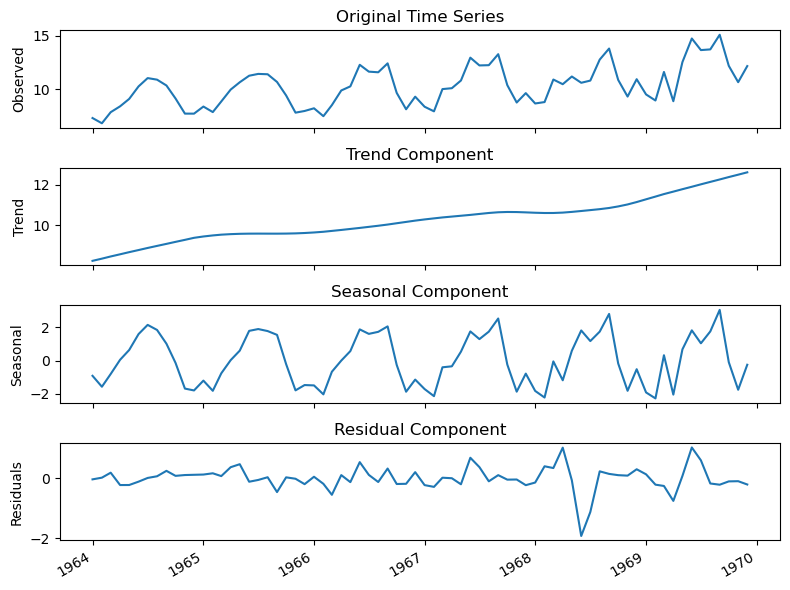

In [13]:
decom_air = STL(air_series, period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(8,6))

ax1.plot(decom_air.observed)
ax1.set_ylabel('Observed')
ax1.set_title("Original Time Series")

ax2.plot(decom_air.trend)
ax2.set_ylabel('Trend')
ax2.set_title("Trend Component")

ax3.plot(decom_air.seasonal)
ax3.set_ylabel('Seasonal')
ax3.set_title("Seasonal Component")

ax4.plot(decom_air.resid)
ax4.set_ylabel('Residuals')
ax4.set_title("Residual Component")

fig.autofmt_xdate()
plt.tight_layout()
plt.show();

In [16]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(decom_air.seasonal)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -5.1599
p-value: 0.0000

p-value < alpha; Ha: Stationary


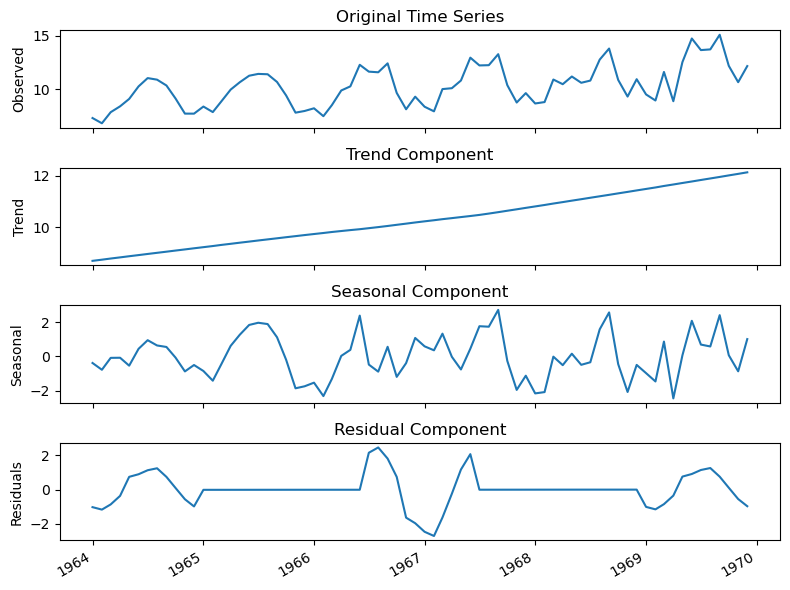

In [17]:
decom_air = STL(air_series, period=30).fit() #<==== m = 30

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(8,6))

ax1.plot(decom_air.observed)
ax1.set_ylabel('Observed')
ax1.set_title("Original Time Series")

ax2.plot(decom_air.trend)
ax2.set_ylabel('Trend')
ax2.set_title("Trend Component")

ax3.plot(decom_air.seasonal)
ax3.set_ylabel('Seasonal')
ax3.set_title("Seasonal Component")

ax4.plot(decom_air.resid)
ax4.set_ylabel('Residuals')
ax4.set_title("Residual Component")

fig.autofmt_xdate()
plt.tight_layout()
plt.show();

In [18]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(decom_air.seasonal)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -2.6371
p-value: 0.0856

p-value > alpha; H0: Not Stationary


In [20]:
# Difference the series if non-stationary
diff_series = decom_air.seasonal.diff().dropna()

# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(diff_series)

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -5.6915
p-value: 0.0000

p-value < alpha; Ha: Stationary


    D = 1

In [23]:
# Perform a full search over the same grid as your manual SARIMAX model
auto_model = pm.auto_arima(
    air_series,                 # The time series data
    seasonal=True,              # Enable seasonal component
    m=30,                       # 30 months (seasonal period)
    d=1,                        # Set differencing 
    D=1,                        # Set seasonal differencing
    start_p=0, max_p=3,         # p from 0 to 2
    start_q=0, max_q=3,         # q from 0 to 2
    start_P=0, max_P=3,         # P from 0 to 2
    start_Q=0, max_Q=3,         # Q from 0 to 2
    stepwise=False,             # Disable stepwise search (enable full grid search)
    trace=True,                 # Print model search progress
    error_action='ignore',      # Ignore errors and continue
    suppress_warnings=True,     # Suppress convergence warnings
    information_criterion='aic' # Use AIC to choose the best model
)

 ARIMA(0,1,0)(0,1,0)[30]             : AIC=173.093, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[30]             : AIC=inf, Time=1.85 sec
 ARIMA(0,1,0)(0,1,2)[30]             : AIC=172.697, Time=1.33 sec
 ARIMA(0,1,0)(0,1,3)[30]             : AIC=174.697, Time=2.38 sec
 ARIMA(0,1,0)(1,1,0)[30]             : AIC=170.697, Time=0.30 sec
 ARIMA(0,1,0)(1,1,1)[30]             : AIC=172.697, Time=0.48 sec
 ARIMA(0,1,0)(1,1,2)[30]             : AIC=174.697, Time=1.33 sec
 ARIMA(0,1,0)(1,1,3)[30]             : AIC=176.697, Time=2.61 sec
 ARIMA(0,1,0)(2,1,0)[30]             : AIC=172.697, Time=1.07 sec
 ARIMA(0,1,0)(2,1,1)[30]             : AIC=174.697, Time=1.57 sec
 ARIMA(0,1,0)(2,1,2)[30]             : AIC=176.697, Time=1.53 sec
 ARIMA(0,1,0)(2,1,3)[30]             : AIC=178.697, Time=3.19 sec
 ARIMA(0,1,0)(3,1,0)[30]             : AIC=174.697, Time=2.10 sec
 ARIMA(0,1,0)(3,1,1)[30]             : AIC=176.697, Time=2.90 sec
 ARIMA(0,1,0)(3,1,2)[30]             : AIC=178.697, Time=2.77 sec
 ARIMA(0,1,1)(

In [28]:
# Perform a full search over the same grid as your manual SARIMAX model
auto_model = pm.auto_arima(
    air_series,                 # The time series data
    seasonal=True,              # Enable seasonal component
    m=12,                       # 12 months (seasonal period)
    d=1,                        # Set differencing 
    D=1,                        # Set seasonal differencing
    start_p=0, max_p=3,         # p from 0 to 2
    start_q=0, max_q=3,         # q from 0 to 2
    start_P=0, max_P=3,         # P from 0 to 2
    start_Q=0, max_Q=3,         # Q from 0 to 2
    stepwise=False,             # Disable stepwise search (enable full grid search)
    trace=True,                 # Print model search progress
    error_action='ignore',      # Ignore errors and continue
    suppress_warnings=True,     # Suppress convergence warnings
    information_criterion='aic' # Use AIC to choose the best model
)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=166.902, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=165.608, Time=0.04 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=167.000, Time=0.14 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=168.786, Time=0.56 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=165.333, Time=0.03 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=167.328, Time=0.22 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=168.914, Time=0.16 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=inf, Time=3.29 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=167.321, Time=0.08 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.49 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=170.534, Time=0.51 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=172.534, Time=1.30 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=168.572, Time=0.53 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=170.534, Time=2.80 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=172.534, Time=1.38 sec
 ARIMA(0,1,1)(0,1,

In [26]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    return combo                                    # Return the list of combinations


P_ns, Q_ns = [list(range(4))]*2          # Define search ranges for non-seasonal parameters (p, q): each from 0 to 3
P_s, Q_s = [list(range(4))]*2             # Define search ranges for seasonal parameters (P, Q): each from 0 to 3
d = 1
D = 1
S = 30

vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

score = {}                                     # Dictionary to store model evaluation metrics

for i, (p, d, q, P, D, Q) in enumerate(vals):  # Iterate over all parameter combinations
    if i % 15 == 0:                            # Print progress every 15 models
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},{S})')

    m = SARIMAX(air_series,                    # Define SARIMA model with current parameter set
                order=(p,d,q), 
                seasonal_order=(P, D, Q, S),   # Particular case m = 30
                enforce_stationarity=False)    # Allow non-stationary models for broader search

    res = m.fit(disp=0, low_memory=True)       # Fit the model silently

    score[i] = {                               # Store model results and evaluation metrics
        'non-seasonal order': (p, d, q),      
        'seasonal order': (P, D, Q),
        'AIC': res.aic,                        # Akaike Information Criterion
        'AICc': res.aicc,                      # Corrected AIC
        'model': res                           # Fitted model object
    }
print()

pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()

Running model #0 using SARIMA(0,1,0)(0,1,0,30)
Running model #15 using SARIMA(0,1,0)(3,1,3,30)
Running model #30 using SARIMA(0,1,1)(3,1,2,30)
Running model #45 using SARIMA(0,1,2)(3,1,1,30)
Running model #60 using SARIMA(0,1,3)(3,1,0,30)
Running model #75 using SARIMA(1,1,0)(2,1,3,30)
Running model #90 using SARIMA(1,1,1)(2,1,2,30)
Running model #105 using SARIMA(1,1,2)(2,1,1,30)
Running model #120 using SARIMA(1,1,3)(2,1,0,30)
Running model #135 using SARIMA(2,1,0)(1,1,3,30)
Running model #150 using SARIMA(2,1,1)(1,1,2,30)
Running model #165 using SARIMA(2,1,2)(1,1,1,30)
Running model #180 using SARIMA(2,1,3)(1,1,0,30)
Running model #195 using SARIMA(3,1,0)(0,1,3,30)
Running model #210 using SARIMA(3,1,1)(0,1,2,30)
Running model #225 using SARIMA(3,1,2)(0,1,1,30)
Running model #240 using SARIMA(3,1,3)(0,1,0,30)
Running model #255 using SARIMA(3,1,3)(3,1,3,30)


In [31]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]  # Generate Cartesian product of input lists
    return combo                                    # Return the list of combinations


P_ns, Q_ns = [list(range(4))]*2          # Define search ranges for non-seasonal parameters (p, q): each from 0 to 3
P_s, Q_s = [list(range(4))]*2             # Define search ranges for seasonal parameters (P, Q): each from 0 to 3
d = 1
D = 1
S = 12

vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

score = {}                                     # Dictionary to store model evaluation metrics

for i, (p, d, q, P, D, Q) in enumerate(vals):  # Iterate over all parameter combinations
    if i % 15 == 0:                            # Print progress every 15 models
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},{S})')

    m = SARIMAX(air_series,                    # Define SARIMA model with current parameter set
                order=(p,d,q), 
                seasonal_order=(P, D, Q, S),   # Particular case m = 30
                enforce_stationarity=False)    # Allow non-stationary models for broader search

    res = m.fit(disp=0, low_memory=True)       # Fit the model silently

    score[i] = {                               # Store model results and evaluation metrics
        'non-seasonal order': (p, d, q),      
        'seasonal order': (P, D, Q),
        'AIC': res.aic,                        # Akaike Information Criterion
        'AICc': res.aicc,                      # Corrected AIC
        'model': res                           # Fitted model object
    }
print()

pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()

Running model #0 using SARIMA(0,1,0)(0,1,0,12)
Running model #15 using SARIMA(0,1,0)(3,1,3,12)
Running model #30 using SARIMA(0,1,1)(3,1,2,12)
Running model #45 using SARIMA(0,1,2)(3,1,1,12)
Running model #60 using SARIMA(0,1,3)(3,1,0,12)
Running model #75 using SARIMA(1,1,0)(2,1,3,12)
Running model #90 using SARIMA(1,1,1)(2,1,2,12)
Running model #105 using SARIMA(1,1,2)(2,1,1,12)
Running model #120 using SARIMA(1,1,3)(2,1,0,12)


KeyboardInterrupt: 